<a href="https://colab.research.google.com/github/Rogerio-mack/IMT_CD_2025/blob/main/IMT_P4_2025_solucao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<head>
  <meta name="author" content="Rogério de Oliveira">
  <meta institution="author" content="ITM">
</head>

<img src="https://maua.br/images/selo-60-anos-maua.svg" width=300, align="right">
<!-- <h1 align=left><font size = 6, style="color:rgb(200,0,0)"> optional title </font></h1> -->


In [ ]:
#@markdown Nome completo e RA (*\<nome\>, \<RA\>*)
Aluno = 'Daniel Henrique' #@param {type:"string"}
RA_somente_numero = 1115665 #@param {type:"number"}





 # Classificação

 Neste exercício você vai classificar mensagens de grupos previamente categorizados. Você vai avaliar diferentes modelos de classificação e o uso ou não de uma redução de dimensionalidade dos dados para essa classificação. Para isso considere:

 **1. Pré-processamento**

 > Faça a vetorização das mensagens com no máximo 1024 recursos, excluindo as stopwords. Elime também os termos que apareçam em mais de 0.8 (80% das mensagens) e termos muito pouco presentes na coleção (menos de 5 ocorrências). Empregue unigramas e bigramas (`ngram_range=(1, 2)`).

**2. PCA**
 > Reduza os dados a no mínimo 80% da variância dos dados (`random_state=42`).

**3. Classificadores**
> Você vai avaliar os seguintes classificadores:

> - Árvore de Decisão (`random_state=42`)
> - Naive Bayes
> - K-Vizinhos mais Próximos
> - Regressão Logística (`max_iter=1000,random_state=42`)

Variando para Árvore de Decisão, os critérios de seleção dos nós (entre `gini` e `entropy`) e para o K-Vizinhos mais Próximos a métrica de distância (entre `cosine` e `minkowski`).

**4. Decisão do Melhor Modelo**
> Opte pelo melhor modelo e seus parâmetros, pelo que apresentar maior acuracidade optando pelo modelo com dados reduzidos (PCA), já que a redução deve ser significativa, mas desde que a perda de acuracidade não seja maior que 10% (com relação aos dados completos).

**5. Predição dos novos dados**
> Com o modelo selecionado faça as predição dos dados de `new`.

Faça o modelo seguindo as seções de código abaixo e responda em seguida às questões do formulário.


In [ ]:
import pandas as pd

prova = str(RA_somente_numero%2 + 1)
print(f'*** Prova {prova} ***')

path = 'https://github.com/Rogerio-mack/IMT_CD_2025/raw/refs/heads/main/data/'

train = pd.read_csv(path + 'groups_train_' + prova + '.csv')
test = pd.read_csv(path + 'groups_test_' + prova + '.csv')
new = pd.read_csv(path + 'groups_new_' + prova + '.csv')

display(train.head())
display(test.head())
display(new.head())

*** Prova 2 ***


,msg,label
0,NaN,alt.atheism
1,"\n[...]\n\nThese don't seem like ""little thing...",sci.electronics
2,There was an article on Jewish major leaguers ...,talk.politics.misc
3,\nIt appears that Walla Walla College will fil...,sci.electronics
4,\nThe PowerBook 170 hardware doesn't have a wa...,comp.sys.mac.hardware


,msg,label
0,NaN,talk.politics.misc
1,Mac IIsi.\n\nI have had my Q700 running with ...,comp.sys.mac.hardware
2,What I usually use...and this stuff is only go...,alt.atheism
3,"\n\n\n HAHAHAHAHAH. Oh, CHRIST! Oh, HAH...",rec.sport.baseball
4,"\nWell, if you're willing to spend a little m...",alt.atheism


,msg
0,"writes...\n\n\n\n\nOh, probably.\n\nMs. N..."
1,"\n\nWell, if everything wouldn't be okay, then..."
2,\nCareful now folks... Also consider the 90VAC...
3,\nI wholeheartedly endorse it.\n\n I have no p...
4,\nI believe the FPU on the LCIII is always sup...


## 1. Pré-processamento

In [ ]:
train.dropna(inplace=True)
test.dropna(inplace=True)
new.dropna(inplace=True)

X_train = train['msg'].to_list()
y_train = train['label']

X_test = test['msg'].to_list()
y_test = test['label']

X_new = new['msg'].to_list()
X_new = list(X_new)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Vetorizador TF-IDF
vectorizer = TfidfVectorizer(
    max_features=1024,      # número máximo de features
    stop_words="english",   # remove stopwords
    max_df=0.8,             # ignora termos muito frequentes
    min_df=5,               # ignora termos muito raros
    ngram_range=(1, 2),     # unigramas e bigramas
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

## 2. PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.8, random_state=42)
X_train_pca = pca.fit_transform(X_train_tfidf.toarray())
X_test_pca = pca.transform(X_test_tfidf.toarray())

In [ ]:
X_train_tfidf.shape, X_train_pca.shape

((3532, 1024), (3532, 496))

## 3. Classificadores

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

base_estimators = {
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42),
    'GaussianNB': GaussianNB(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'LogisticRegression': LogisticRegression(max_iter=1000,random_state=42),
}

parm_grid = {
    'DecisionTreeClassifier': {'criterion': ['gini','entropy']},
    'GaussianNB': {},
    'KNeighborsClassifier': {'metric': ['cosine','minkowski']},
    'LogisticRegression': {},
}

i = 0
for X_train, X_test, y_train, y_test in [(X_train_tfidf.toarray(), X_test_tfidf.toarray(), y_train, y_test), (X_train_pca, X_test_pca, y_train, y_test)]:
  for name, base_estimator in base_estimators.items():
    clf = GridSearchCV(base_estimator, parm_grid[name], cv=5)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print(f'{['\nTFIDF...','\nPCA...'][i]} best estimator: {clf.best_estimator_} with score {clf.best_score_:.3f} accuracy score in X_test: {clf.score(X_test, y_test):.3f}')
  i = i + 1




TFIDF... best estimator: DecisionTreeClassifier(random_state=42) with score 0.613 accuracy score in X_test: 0.652

TFIDF... best estimator: GaussianNB() with score 0.727 accuracy score in X_test: 0.719

TFIDF... best estimator: KNeighborsClassifier(metric='cosine') with score 0.728 accuracy score in X_test: 0.735

TFIDF... best estimator: LogisticRegression(max_iter=1000, random_state=42) with score 0.794 accuracy score in X_test: 0.820

PCA... best estimator: DecisionTreeClassifier(random_state=42) with score 0.646 accuracy score in X_test: 0.663

PCA... best estimator: GaussianNB() with score 0.674 accuracy score in X_test: 0.718

PCA... best estimator: KNeighborsClassifier(metric='cosine') with score 0.727 accuracy score in X_test: 0.731

PCA... best estimator: LogisticRegression(max_iter=1000, random_state=42) with score 0.797 accuracy score in X_test: 0.818


## 4. Decisão do Melhor Modelo

In [ ]:
model = LogisticRegression(max_iter=1000, random_state=42)

model.fit(X_train_pca, y_train)
y_pred = model.predict(X_test_pca)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
                         precision    recall  f1-score   support

comp.os.ms-windows.misc       0.88      0.85      0.86       188
           misc.forsale       0.87      0.89      0.88       175
              rec.autos       0.89      0.82      0.85       197
 soc.religion.christian       0.93      0.88      0.91       201
     talk.politics.guns       0.73      0.86      0.79       176

               accuracy                           0.86       937
              macro avg       0.86      0.86      0.86       937
           weighted avg       0.86      0.86      0.86       937



## 5. Predição do Novos dados

In [ ]:
X_new_tfidf = vectorizer.transform(X_new)
X_new_pca = pca.transform(X_new_tfidf.toarray())

y_pred = model.predict(X_new_pca)
y_pred

array(['misc.forsale', 'talk.politics.guns', 'comp.os.ms-windows.misc',
       'soc.religion.christian', 'talk.politics.guns', 'rec.autos',
       'comp.os.ms-windows.misc', 'comp.os.ms-windows.misc',
       'talk.politics.guns', 'soc.religion.christian'], dtype=object)

In [ ]:
pd.DataFrame(y_pred).value_counts()

,count
0,
comp.os.ms-windows.misc,3
talk.politics.guns,3
soc.religion.christian,2
rec.autos,1
misc.forsale,1


# Clustering 1

Considere agora o total de mensagens rotuladas (não temos somente dados de treinamento agora). Faça uma clusterização k-médias (`random_state=42, n_init='auto'`) e obtenha a acuracidade de clusterização com relação as classes dos dados.

Em seguinda responda às questões do formulário.

In [ ]:
data = pd.concat([train, test]).reset_index(drop=True)
X = data['msg'].to_list()
y = data['label']


In [ ]:
X = vectorizer.fit_transform(X)
X = pca.fit_transform(X.toarray())

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto')
kmeans.fit(X)

print("Cluster labels:", kmeans.labels_)

Cluster labels: [2 2 3 ... 2 3 0]


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Original labels:", y.unique())
print("Encoded labels:", y_encoded)
print("Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

Original labels: ['soc.religion.christian' 'misc.forsale' 'rec.autos' 'talk.politics.guns'
 'comp.os.ms-windows.misc']
Encoded labels: [3 1 2 ... 0 2 4]
Mapping: {'comp.os.ms-windows.misc': np.int64(0), 'misc.forsale': np.int64(1), 'rec.autos': np.int64(2), 'soc.religion.christian': np.int64(3), 'talk.politics.guns': np.int64(4)}


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
from scipy.stats import mode

def cluster_accuracy(true_labels, cluster_labels):
  """
  Calculate the accuracy of
  """
  # Get true labels and cluster labels
  # true_labels = dataset.target
  # cluster_labels = kmeans.labels_

  # Create a mapping from cluster label to true label
  # This step tries to align the arbitrary cluster labels with the actual target labels
  # by assigning each cluster the true label that is most frequent within it.
  mapped_cluster_labels = np.zeros_like(cluster_labels)
  for i in range(5):
      mask = (cluster_labels == i)
      if np.any(mask): # Check if the cluster is not empty
          # Find the most frequent true label in this cluster
          most_frequent_label = mode(true_labels[mask], keepdims=False).mode
          mapped_cluster_labels[mask] = most_frequent_label

  # Calculate the confusion matrix
  conf_matrix = confusion_matrix(true_labels, mapped_cluster_labels)
  print("Confusion Matrix:")
  print(conf_matrix)

  # Calculate the accuracy score
  accuracy = accuracy_score(true_labels, mapped_cluster_labels)
  print(f"\nAccuracy: {accuracy:.4f}")

  return conf_matrix, accuracy

conf_matrix, accuracy = cluster_accuracy(y_encoded, kmeans.labels_)


Confusion Matrix:
[[761   0  12 169  24]
 [  8   0   2 878   3]
 [110   0 512 334   0]
 [  4   0   2 974   0]
 [ 38   0   2 509 396]]

Accuracy: 0.5578


In [ ]:
conf_matrix.sum(axis=0).argmax(), conf_matrix.sum(axis=0).argmin(),

(np.int64(3), np.int64(1))

In [ ]:
label_encoder.inverse_transform([conf_matrix.sum(axis=0).argmax()]), label_encoder.inverse_transform([conf_matrix.sum(axis=0).argmin()])

(array(['soc.religion.christian'], dtype=object),
 array(['misc.forsale'], dtype=object))

# Clustering 2

Conside um grupo de 60 sinais como abaixo. Você pode supor, por exemplo, que são sinais de freqência emitidos por diferentes materiais quando expostos à luz. Você está interessado encontrar grupo de sinais mais semelhantes entre si - o que evidenciaria materiais com composições mais semelhantes e distintos dos demais. Para isso você irá empregar uma clusterização hierárquica. Empregue o linkage médio e escolha uma métrica de distância que seja inume à escala dos sinais [1, 0, 1], e [2, 1, 2], por exemplo, são sinais semelhantes pois têm o mesmo formato de onda.

**1. Encontre o melhor número de agrupamentos pelo critério da silhueta**

**2. Faça um gráfico contendo o sinal médio de cada cluster**

Em seguinda responda às questões do formulário.

In [ ]:
wave = pd.read_csv(path + 'waveforms_' + prova + '.csv')
display(wave.head())


,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,...,y50,y51,y52,y53,y54,y55,y56,y57,y58,y59
0,-0.638119,0.926391,1.757745,0.886360,0.904188,0.556731,1.107150,0.889050,1.018506,1.933347,...,1.051113,1.207533,-1.242550,3.002773,0.461172,0.756820,0.997992,1.100283,0.365021,1.366578
1,-0.658306,1.118461,1.008007,0.912949,0.870338,-1.366499,0.859288,-1.249620,0.859982,-1.398719,...,0.648958,1.024233,1.189501,2.747872,1.256692,-0.066668,1.419738,0.902108,0.975339,1.207489
2,0.873813,-0.519264,0.823030,1.133530,2.542408,1.159506,0.892151,-0.885014,1.044227,0.617903,...,1.065052,3.804302,2.663532,2.496543,0.922584,0.840337,-0.035382,0.939203,1.393616,0.530962
3,0.635703,1.055288,2.386328,1.003382,2.809194,-0.167039,0.908453,0.680110,1.100892,1.029363,...,1.317029,1.400439,1.186194,0.887685,0.955070,0.651862,-0.460925,1.298271,1.472271,4.437278
4,0.686980,-0.746864,-1.129103,0.979267,0.932712,0.995721,-1.551551,0.988775,-0.256296,0.738302,...,0.979186,3.085337,1.185977,3.030117,1.148174,1.775114,0.833756,2.885672,1.463869,1.252734


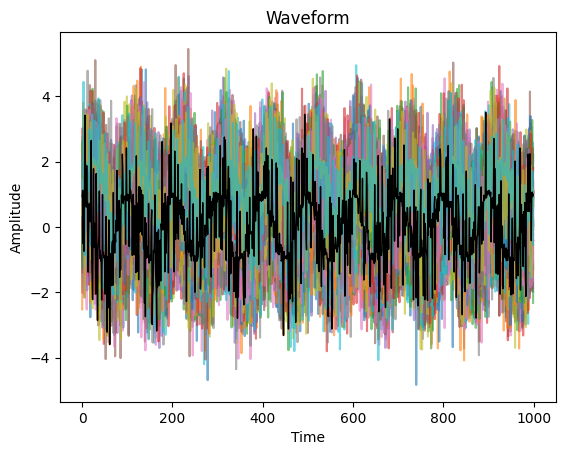

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(wave,alpha=0.6)
plt.plot(wave['y1'], c='k', lw=1)

plt.title('Waveform')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.show()


In [ ]:
X = np.array(wave).T

In [ ]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Define a range of cluster numbers to test
range_n_clusters = range(2, 11) # From 2 to 10 clusters

silhouette_scores = []

# Loop through each number of clusters
for n_clusters in range_n_clusters:
    hclust_model = AgglomerativeClustering(n_clusters=n_clusters, metric='cosine', linkage="average")
    # Fit the KMeans model to the X_cluster data
    hclust_model.fit(X)

    # Predict the cluster labels
    cluster_labels = hclust_model.labels_

    # Calculate the silhouette score
    score = silhouette_score(X, cluster_labels)
    silhouette_scores.append(score)

    print(f"For n_clusters = {n_clusters}, the silhouette score is : {score:.4f}")

# Identify the optimal number of clusters
optimal_n_clusters_idx = np.argmax(silhouette_scores)
optimal_n_clusters = range_n_clusters[optimal_n_clusters_idx]

print(f"\nThe optimal number of clusters is {optimal_n_clusters} with a silhouette score of {silhouette_scores[optimal_n_clusters_idx]:.4f}")

For n_clusters = 2, the silhouette score is : 0.1895
For n_clusters = 3, the silhouette score is : 0.1975
For n_clusters = 4, the silhouette score is : 0.1385
For n_clusters = 5, the silhouette score is : 0.0754
For n_clusters = 6, the silhouette score is : 0.0669
For n_clusters = 7, the silhouette score is : 0.0669
For n_clusters = 8, the silhouette score is : 0.0672
For n_clusters = 9, the silhouette score is : 0.0670
For n_clusters = 10, the silhouette score is : 0.0668

The optimal number of clusters is 3 with a silhouette score of 0.1975


In [ ]:
hclust_model = AgglomerativeClustering(n_clusters=3, metric='cosine', linkage="average")
hclust_model.fit(X)

print("Cluster labels:", hclust_model.labels_)


Cluster labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


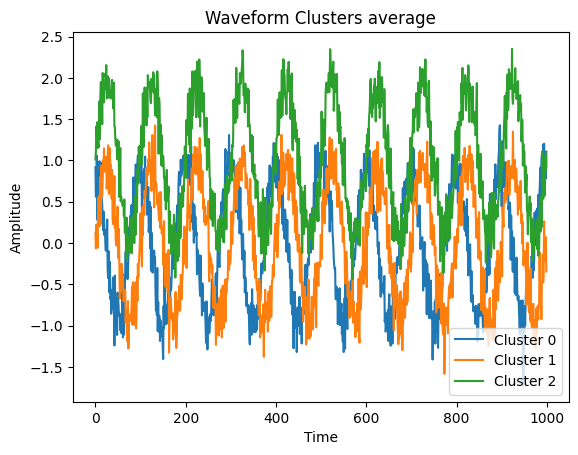

In [ ]:
for i in set(hclust_model.labels_):
  plt.plot(X[hclust_model.labels_ == i][:,:].mean(axis=0),label=f'Cluster {i}')

plt.legend()
plt.title('Waveform Clusters average')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.show()
